# GEPA

In [ ]:
import json
from fastcore.utils import *

In [ ]:
with open('raw_data_backup.json', 'r') as f:
    convos = json.load(f)

In [ ]:
convo = convos[0]
convo

{'fields': {'input': "agent: Hi, good afternoon — this is Maya calling from American Express. Am I speaking with Jordan Lee?\n\ncustomer: Yes, this is Jordan.\n\nagent: Great, Jordan. How are you doing today?\n\ncustomer: I'm good, thanks. Busy afternoon, but I have a few minutes.\n\nagent: I appreciate you taking the time. I see you’ve been an American Express cardmember for about three years — thank you for that. The reason I’m calling is we’re reaching out to select cardmembers about an opportunity to upgrade to a rewards card that could better match your spending patterns and save you money overall. Do you have about ten minutes to talk about what might work best for you?\n\ncustomer: Sure, ten minutes works.\n\nagent: Perfect. Before I jump into options, can I ask a couple quick questions so I can recommend the best fit? This is just to understand how you use your card — how often do you travel for work or leisure, say per year?\n\ncustomer: Maybe two or three trips a year for wor

In [ ]:
print(convo['fields']['input'])

agent: Hi, good afternoon — this is Maya calling from American Express. Am I speaking with Jordan Lee?

customer: Yes, this is Jordan.

agent: Great, Jordan. How are you doing today?

customer: I'm good, thanks. Busy afternoon, but I have a few minutes.

agent: I appreciate you taking the time. I see you’ve been an American Express cardmember for about three years — thank you for that. The reason I’m calling is we’re reaching out to select cardmembers about an opportunity to upgrade to a rewards card that could better match your spending patterns and save you money overall. Do you have about ten minutes to talk about what might work best for you?

customer: Sure, ten minutes works.

agent: Perfect. Before I jump into options, can I ask a couple quick questions so I can recommend the best fit? This is just to understand how you use your card — how often do you travel for work or leisure, say per year?

customer: Maybe two or three trips a year for work and a vacation once a year.

agent

In [ ]:
convo.keys()

dict_keys(['fields', 'answer', 'call_quality'])

In [ ]:
import dspy
lm = dspy.LM("openai/gpt-5-nano", api_key=os.environ['OPENAI_API_KEY'], temperature=1.0, max_tokens = 16000)
dspy.configure(lm=lm)

In [ ]:
with open('raw_data_backup.json', 'r') as f:
    convos = json.load(f)
convos[0]

{'fields': {'input': "agent: Hi, good afternoon — this is Maya calling from American Express. Am I speaking with Jordan Lee?\n\ncustomer: Yes, this is Jordan.\n\nagent: Great, Jordan. How are you doing today?\n\ncustomer: I'm good, thanks. Busy afternoon, but I have a few minutes.\n\nagent: I appreciate you taking the time. I see you’ve been an American Express cardmember for about three years — thank you for that. The reason I’m calling is we’re reaching out to select cardmembers about an opportunity to upgrade to a rewards card that could better match your spending patterns and save you money overall. Do you have about ten minutes to talk about what might work best for you?\n\ncustomer: Sure, ten minutes works.\n\nagent: Perfect. Before I jump into options, can I ask a couple quick questions so I can recommend the best fit? This is just to understand how you use your card — how often do you travel for work or leisure, say per year?\n\ncustomer: Maybe two or three trips a year for wor

In [ ]:
convos = [d for d in convos if isinstance(d['fields'], dict)]
len(convos)

27

In [ ]:
dspy_dataset = [
    dspy.Example({
        "message": d['fields']['input'],
        "answer": d['answer'],
        "final_result":d['call_quality']
    }).with_inputs("message")
    for d in convos
]

In [ ]:
print(dspy_dataset[0])

Example({'message': "agent: Hi, good afternoon — this is Maya calling from American Express. Am I speaking with Jordan Lee?\n\ncustomer: Yes, this is Jordan.\n\nagent: Great, Jordan. How are you doing today?\n\ncustomer: I'm good, thanks. Busy afternoon, but I have a few minutes.\n\nagent: I appreciate you taking the time. I see you’ve been an American Express cardmember for about three years — thank you for that. The reason I’m calling is we’re reaching out to select cardmembers about an opportunity to upgrade to a rewards card that could better match your spending patterns and save you money overall. Do you have about ten minutes to talk about what might work best for you?\n\ncustomer: Sure, ten minutes works.\n\nagent: Perfect. Before I jump into options, can I ask a couple quick questions so I can recommend the best fit? This is just to understand how you use your card — how often do you travel for work or leisure, say per year?\n\ncustomer: Maybe two or three trips a year for work

In [ ]:
train_set = dspy_dataset[:int(len(dspy_dataset) * 0.33)]
val_set = dspy_dataset[int(len(dspy_dataset) * 0.33):int(len(dspy_dataset) * 0.66)]
test_set = dspy_dataset[int(len(dspy_dataset) * 0.66):]
len(train_set), len(val_set), len(test_set)

(8, 9, 10)

In [ ]:
print("Input Message:")
print(train_set[0]['message'])

print("\n\nGold Answer:")
for k, v in json.loads(train_set[0]['answer']).items():
    print(f"{k}: {v}")

Input Message:
agent: Hi, good afternoon — this is Maya calling from American Express. Am I speaking with Jordan Lee?

customer: Yes, this is Jordan.

agent: Great, Jordan. How are you doing today?

customer: I'm good, thanks. Busy afternoon, but I have a few minutes.

agent: I appreciate you taking the time. I see you’ve been an American Express cardmember for about three years — thank you for that. The reason I’m calling is we’re reaching out to select cardmembers about an opportunity to upgrade to a rewards card that could better match your spending patterns and save you money overall. Do you have about ten minutes to talk about what might work best for you?

customer: Sure, ten minutes works.

agent: Perfect. Before I jump into options, can I ask a couple quick questions so I can recommend the best fit? This is just to understand how you use your card — how often do you travel for work or leisure, say per year?

customer: Maybe two or three trips a year for work and a vacation once

In [ ]:
from typing import List, Literal

class CallAnalysis(dspy.Signature):
    """
    Read the provided call transcript and analyze it comprehensively.
    Determine both: (1) which categories the agent displayed, and (2) whether the call will lead to conversion or customer retention.
    """
    message: str = dspy.InputField()
    categories: List[Literal["introduction_rapport_building", "need_assessment_qualification", "value_proposition_feature_mapping", "objection_handling", "benefit_reinforcement", "risk_reduction_trust_building", "call_to_action_closing"]] = dspy.OutputField()
    final_result: Literal['good', 'bad'] = dspy.OutputField()

class CallAnalysisAgent(dspy.Module):
    def __init__(self):
        self.predict = dspy.ChainOfThought(CallAnalysis)
    
    def forward(self, message: str):
        result = self.predict(message=message)
        return dspy.Prediction(
            categories=result.categories,
            final_result=result.final_result
        )

program = CallAnalysisAgent()

In [ ]:
program

predict.predict = Predict(StringSignature(message -> reasoning, categories, final_result
    instructions='Read the provided call transcript and analyze it comprehensively.\nDetermine both: (1) which categories the agent displayed, and (2) whether the call will lead to conversion or customer retention.'
    message = Field(annotation=str required=True json_schema_extra={'__dspy_field_type': 'input', 'prefix': 'Message:', 'desc': '${message}'})
    reasoning = Field(annotation=str required=True json_schema_extra={'prefix': "Reasoning: Let's think step by step in order to", 'desc': '${reasoning}', '__dspy_field_type': 'output'})
    categories = Field(annotation=List[Literal['introduction_rapport_building', 'need_assessment_qualification', 'value_proposition_feature_mapping', 'objection_handling', 'benefit_reinforcement', 'risk_reduction_trust_building', 'call_to_action_closing']] required=True json_schema_extra={'__dspy_field_type': 'output', 'prefix': 'Categories:', 'desc': '${categori

In [ ]:
program(train_set[0]['message'])

Prediction(
    categories=['introduction_rapport_building', 'need_assessment_qualification', 'value_proposition_feature_mapping', 'objection_handling', 'risk_reduction_trust_building', 'benefit_reinforcement', 'call_to_action_closing'],
    final_result='good'
)

In [ ]:
def score_final_res(gold, pred):
    """Compute score for the final result."""
    score = 1.0 if gold == pred else 0.0
    return score

def score_categories(gold_categories, pred_categories):
    """Compute score for categories - counts matches and correct exclusions."""
    correct = 0
    for k, v in gold_categories.items():
        if v and k in pred_categories:
            correct += 1
        elif not v and k not in pred_categories:
            correct += 1
    score = correct / len(gold_categories)
    
    return score

def metric(example, pred, trace=None, pred_name=None, pred_trace=None):
    """Overall metric combining both scores."""
    gold_cat = json.loads(example['answer'])
    gold_final_res = example['final_result']
    
    score_final_res_val = score_final_res(gold_final_res, pred.final_result)
    score_categories_val = score_categories(gold_cat, pred.categories)
    
    total = (score_final_res_val + score_categories_val) / 2
    return total


In [ ]:
evaluate = dspy.Evaluate(
    devset=test_set,
    metric=metric,
    display_table=True,
    display_progress=True
)

evaluate(program)

Average Metric: 7.21 / 10 (72.1%): 100%|██████████| 10/10 [00:00<00:00, 246.37it/s]

2025/10/14 20:54:01 INFO dspy.evaluate.evaluate: Average Metric: 7.214285714285714 / 10 (72.1%)


,message,answer,example_final_result,categories,pred_final_result,metric
0,"agent: Hi! Good morning—this is Tyler calling from Amex, how are y...","{""introduction_rapport_building"": true, ""need_assessment_qualifica...",bad,"[introduction_rapport_building, need_assessment_qualification, val...",good,✔️ [0.429]
1,agent: Hi! This is Marissa calling from Amex—American Express—how ...,"{""introduction_rapport_building"": true, ""need_assessment_qualifica...",bad,"[introduction_rapport_building, need_assessment_qualification, val...",good,✔️ [0.429]
2,"agent: Hi, good afternoon — this is Jenna calling from American Ex...","{""introduction_rapport_building"": true, ""need_assessment_qualifica...",good,"[introduction_rapport_building, need_assessment_qualification, val...",good,✔️ [0.857]
3,"agent: Hi, good afternoon! This is Marissa calling from Amex, how ...","{""introduction_rapport_building"": true, ""need_assessment_qualifica...",bad,"[introduction_rapport_building, value_proposition_feature_mapping,...",bad,✔️ [0.929]
4,"agent: Hi, good afternoon! This is Sam calling from American Expre...","{""introduction_rapport_building"": true, ""need_assessment_qualifica...",bad,"[introduction_rapport_building, need_assessment_qualification, val...",bad,✔️ [0.857]
5,"agent: Hi, this is Maria calling from American Express. Am I speak...","{""introduction_rapport_building"": false, ""need_assessment_qualific...",good,"[introduction_rapport_building, need_assessment_qualification, val...",good,✔️ [0.857]
6,"agent: Hi, this is Maria calling from American Express. Am I speak...","{""introduction_rapport_building"": true, ""need_assessment_qualifica...",good,"[introduction_rapport_building, need_assessment_qualification, val...",good,✔️ [0.929]
7,"agent: Hi, this is Maya calling from American Express. Am I speaki...","{""introduction_rapport_building"": true, ""need_assessment_qualifica...",good,"[introduction_rapport_building, need_assessment_qualification, val...",good,✔️ [0.857]
8,"agent: Hi, this is Mark from Amex, calling about our credit soluti...","{""introduction_rapport_building"": false, ""need_assessment_qualific...",bad,"[introduction_rapport_building, need_assessment_qualification, val...",good,✔️ [0.286]
9,"agent: Hello, this is Amex calling, this is John from American Exp...","{""introduction_rapport_building"": false, ""need_assessment_qualific...",bad,"[need_assessment_qualification, value_proposition_feature_mapping,...",bad,✔️ [0.786]


EvaluationResult(score=72.14, results=<list of 10 results>)

In [ ]:
def feedback_final_res(gold, pred):
    """
    Generate feedback for final result module.
    """
    score = 1.0 if gold == pred else 0.0
    if gold == pred:
        feedback = f"You correctly classified the sales call as `{gold}`. This sales call is indeed `{gold}`."
    else:
        feedback = f"You incorrectly classified the sales call as `{gold}`. The correct sales call is `{gold}`. Think about how you could have reasoned to get the correct sales call label."
    return feedback, score

def feedback_categories(gold_categories, pred_categories):
    """
    Generate feedback for the categories module.
    Uses the same match/mismatch logic as category accuracy in the score.
    """
    correctly_included = [k for k, v in gold_categories.items() if v and k in pred_categories]
    incorrectly_included = [k for k, v in gold_categories.items() if not v and k in pred_categories]
    incorrectly_excluded = [k for k, v in gold_categories.items() if v and k not in pred_categories]
    correctly_excluded = [k for k, v in gold_categories.items() if not v and k not in pred_categories]  # For completeness in accuracy check

    # Recompute category accuracy (matches score logic)
    score = (len(correctly_included) + len(correctly_excluded)) / len(gold_categories)

    if score == 1.0:
        fb_text = f"The category classification is perfect. You correctly identified that the agent uses the following categories: `{repr(correctly_included)}`."
    else:
        fb_text = f"The category classification is not perfect. You correctly identified that the agent uses the following categories: `{repr(correctly_included)}`.\n"
        if incorrectly_included:
            fb_text += f"However, you incorrectly identified that the agent uses the following categories: `{repr(incorrectly_included)}`. The agent DOES NOT use these categories.\n"
        if incorrectly_excluded:
            prefix = "Additionally, " if incorrectly_included else "However, "
            fb_text += f"{prefix}you didn't identify the following categories that the agent used. categories you missed: `{repr(incorrectly_excluded)}`.\n"
        fb_text += "Think about how you could have reasoned to get the correct category labels."
    return fb_text, score

def metric_with_feedback(example, pred, trace=None, pred_name=None, pred_trace=None):
    """
    Computes a score and provides feedback for the call analysis prediction.
    Returns total score if pred_name is None, otherwise returns dspy.Prediction with score and feedback.
    """
    # Parse gold standard from example
    gold_cat = json.loads(example['answer'])
    gold_final_res = example['final_result']
    
    # Compute feedback and scores
    fb_final_res, score_final_res_val = feedback_final_res(gold_final_res, pred.final_result)
    fb_categories, score_categories_val = feedback_categories(gold_cat, pred.categories)
    
    # Overall score
    total = (score_final_res_val + score_categories_val) / 2
    
    # If no specific predictor requested, return just the score
    if pred_name is None:
        return total
    
    # Return feedback for the specific predictor module
    elif pred_name == 'final_res_module.predict':
        feedback = fb_final_res
    elif pred_name == 'categories_module.predict':
        feedback = fb_categories
    else:
        feedback = "No feedback available for this module."
    
    return dspy.Prediction(score=total, feedback=feedback)

In [ ]:
from dspy import GEPA

optimizer = GEPA(
    metric=metric_with_feedback,
    auto="light", # <-- We will use a light budget for this tutorial. However, we typically recommend using auto="heavy" for optimized performance!
    num_threads=32,
    track_stats=True,
    use_merge=False,
    reflection_lm=dspy.LM(model="gpt-5-nano", temperature=1.0, max_tokens=16000)
)

In [ ]:
optimized_program = optimizer.compile(
    program,
    trainset=train_set,
    valset=val_set,
)

2025/10/14 20:56:56 INFO dspy.teleprompt.gepa.gepa: Running GEPA for approx 416 metric calls of the program. This amounts to 24.47 full evals on the train+val set.
2025/10/14 20:56:56 INFO dspy.teleprompt.gepa.gepa: Using 9 examples for tracking Pareto scores. You can consider using a smaller sample of the valset to allow GEPA to explore more diverse solutions within the same budget.
2025/10/14 20:56:56 INFO dspy.evaluate.evaluate: Average Metric: 6.428571428571429 / 9 (71.4%)
2025/10/14 20:56:56 INFO dspy.teleprompt.gepa.gepa: Iteration 0: Base program full valset score: 0.7142857142857143
2025/10/14 20:56:56 INFO dspy.teleprompt.gepa.gepa: Iteration 1: Selected program 0 score: 0.7142857142857143


Average Metric: 1.79 / 3 (59.5%): 100%|██████████| 3/3 [00:00<00:00, 200.01it/s]

2025/10/14 20:56:56 INFO dspy.evaluate.evaluate: Average Metric: 1.7857142857142856 / 3 (59.5%)


2025/10/14 20:57:20 INFO dspy.teleprompt.gepa.gepa: Iteration 1: Proposed new text for predict.predict: text
You are a transcript analysis assistant for evaluating outbound call conversations in a financial services context (e.g., credit cards, merchant services). Your job is to read a single call transcript and produce a structured assessment of agent behavior and likely outcomes.

Input format you will receive
- A plain-text transcript labeled with lines beginning "agent:" and "customer:" (and possibly stage directions or brief metadata). There is typically one transcript per task.

What you must produce
- reasoning: A concise, high-level justification that connects observable content in the transcript to the identified categories and the final outcome. Do not reveal internal chain-of-thought or the exact step-by-step reasoning process; keep it brief and focused on observable evidence (what the agent said/did and what the customer said/did).
- categories: A Python-list-like sequence 

Average Metric: 1.79 / 3 (59.5%): 100%|██████████| 3/3 [00:20<00:00,  6.82s/it]

2025/10/14 20:58:13 INFO dspy.evaluate.evaluate: Average Metric: 1.7857142857142858 / 3 (59.5%)


2025/10/14 20:58:36 INFO dspy.teleprompt.gepa.gepa: Iteration 2: Proposed new text for predict.predict: You are a transcript analysis assistant focused on evaluating agent-customer call transcripts for financial products (e.g., Amex-style cards and business programs). Your job is to read the provided call transcript (found in the input under the "message" section) and produce a structured analysis that helps determine two things: (1) which behavioral categories the agent demonstrated, and (2) whether the call is oriented toward conversion or customer retention (or both). Follow the exact output format described below.

What you must do
- Read the transcript carefully and base every conclusion solely on what is stated in the conversation.
- Identify all instances where the agent demonstrates any of the predefined categories (see list). If a turn clearly maps to a category, mark it accordingly. Do not invent categories beyond the fixed set.
- Provide a clear assessment of the likely outc

Average Metric: 1.93 / 3 (64.3%): 100%|██████████| 3/3 [00:18<00:00,  6.20s/it]

2025/10/14 20:59:58 INFO dspy.evaluate.evaluate: Average Metric: 1.9285714285714286 / 3 (64.3%)


2025/10/14 21:00:20 INFO dspy.teleprompt.gepa.gepa: Iteration 3: Proposed new text for predict.predict: New task instruction for the assistant

Goal
- Given a call transcript between an agent and a customer, produce a structured, justified assessment that (a) identifies all of the agent behavior categories demonstrated in the transcript, and (b) determines whether the call is oriented toward conversion (a sale/application) or customer retention (deflection, retention, or information framing without active sale). Use a fixed taxonomy and a transparent justification.

Input format you will receive
- A single transcript containing lines that typically begin with "agent: ..." and "customer: ...". In some transcripts, you may also see embedded tokens indicating observed categories (e.g., introduction_rapport_building) sprinkled in. You should:
  - Ignore any embedded category tokens when analyzing content (treat them as metadata), and base your analysis strictly on the spoken content.
  - R

Average Metric: 1.71 / 3 (57.1%): 100%|██████████| 3/3 [00:00<00:00, 221.30it/s]

2025/10/14 21:00:52 INFO dspy.evaluate.evaluate: Average Metric: 1.7142857142857144 / 3 (57.1%)


2025/10/14 21:01:18 INFO dspy.teleprompt.gepa.gepa: Iteration 4: Proposed new text for predict.predict: instruction
Task description
- You will be given a call transcript between an agent and a customer. Your job is twofold:
  1) identify which category pillars the agent demonstrates during the call.
  2) determine whether the call is trending toward conversion (the customer signs up, applies, or there is a clear path to an immediate sale) or toward customer retention (the goal is to keep the relationship, reduce risk, schedule follow-ups, or set up onboarding), including any concrete next steps that support that outcome.

Input format to expect
- The transcript is plain text with lines beginning with "agent:" and "customer:". Some transcripts may include inline tags indicating the category already (e.g., introduction_rapport_building) placed in the transcript. Do not assume such tags will always be present.

What you must output
- Provide three sections in this exact structure:
  1) r

Average Metric: 2.14 / 3 (71.4%): 100%|██████████| 3/3 [00:00<00:00, 37.13it/s]

2025/10/14 21:02:15 INFO dspy.evaluate.evaluate: Average Metric: 2.142857142857143 / 3 (71.4%)


2025/10/14 21:02:38 INFO dspy.teleprompt.gepa.gepa: Iteration 5: Proposed new text for predict.predict: New instruction for transcript analyst

Goal
- Given a call transcript between an agent and a customer, determine two things:
  1) Which of the predefined agent behavior categories are demonstrated in the transcript.
  2) Whether the call is likely to lead to conversion (customer signs up, accepts a paid product, or initiates a formal application) or to retention (customer remains with current product/plan or is kept from churn) based on the conversation content and next-step signals.

Input format you will receive
- A single transcript text containing alternating lines that begin with:
  - agent: ...
  - customer: ...
- The transcript may include inline tokens at the end of lines (e.g., introduction_rapport_building) that annotate the category for that line. Do not rely on these tokens for your analysis; treat them as hints only. Base your categorization on the actual spoken content

Average Metric: 2.07 / 3 (69.0%): 100%|██████████| 3/3 [00:00<00:00, 306.47it/s]

2025/10/14 21:03:05 INFO dspy.evaluate.evaluate: Average Metric: 2.0714285714285716 / 3 (69.0%)


2025/10/14 21:03:28 INFO dspy.teleprompt.gepa.gepa: Iteration 6: Proposed new text for predict.predict: Role and goal
- You are a transcript analyzer for outbound/upsell calls in a credit-card context (e.g., Amex-style upgrade offers, annual-fee vs no-fee options, welcome bonuses, soft vs hard inquiries).
- Your job is to read a provided call transcript, identify the agent behaviors that map to a fixed set of categories, and judge whether the conversation is trending toward conversion (the user adopting a new product/upgrade) or customer retention (no upgrade, staying with existing product, or only informational follow-up). You should also surface compelling evidence from the transcript that supports your judgment.

Input format you will receive
- A full agent–customer call transcript with lines prefixed by “agent:” and “customer:” (as in the examples).

What to produce (structured output)
- reasoning: A clear, concise narrative explaining why you assigned each category and why the fin

Average Metric: 2.00 / 3 (66.7%): 100%|██████████| 3/3 [00:00<00:00, 75.59it/s]

2025/10/14 21:04:07 INFO dspy.evaluate.evaluate: Average Metric: 2.0 / 3 (66.7%)


2025/10/14 21:04:36 INFO dspy.teleprompt.gepa.gepa: Iteration 7: Proposed new text for predict.predict: New Task Instruction for Transcript Analysis

Goal
- Given a customer-agent call transcript, produce a structured analysis that (a) identifies which of a fixed set of agent-behavior categories are displayed, and (b) judges whether the call is likely to result in a conversion (sale of a new product/upgrade) or a retention scenario (customer retained with no sale of a new product).

Input
- A single call transcript string. The transcript will contain lines with agent and customer dialogue. In some transcripts, category tags may be embedded in the text (e.g., “introduction_rapport_building” at the end of a line) or implied by the content of the lines.

Categories (exact tokens to detect)
- introduction_rapport_building
- need_assessment_qualification
- value_proposition_feature_mapping
- objection_handling
- benefit_reinforcement
- risk_reduction_trust_building
- call_to_action_closing


Average Metric: 2.21 / 3 (73.8%): 100%|██████████| 3/3 [00:00<00:00, 137.55it/s]

2025/10/14 21:05:00 INFO dspy.evaluate.evaluate: Average Metric: 2.2142857142857144 / 3 (73.8%)


2025/10/14 21:05:26 INFO dspy.teleprompt.gepa.gepa: Iteration 8: Proposed new text for predict.predict: You are an analysis assistant specialized in evaluating call transcripts for financial product conversations (e.g., credit cards, business cards, upgrades, etc.). Your task is to read a provided transcript and produce a structured assessment that highlights how the agent performed and what the call implies for future outcomes.

Input format to expect
- A plain-text transcript containing lines that begin with: 
  - agent: <dialogue from the agent>
  - customer: <dialogue from the customer>
- The transcript may include multiple turns, references to fees, credits, protections, trial windows, privacy/opt-out, and next-step actions (e.g., emails, follow-up calls, application links, soft/hard pulls).

What you must produce
1) reasoning
- Provide a concise, narrative summary of the agent’s approach and behaviors observed in the transcript.
- Highlight key strategies (e.g., rapport building,

Average Metric: 1.64 / 3 (54.8%): 100%|██████████| 3/3 [01:43<00:00, 34.61s/it]

2025/10/14 21:09:40 INFO dspy.evaluate.evaluate: Average Metric: 1.6428571428571428 / 3 (54.8%)


2025/10/14 21:10:11 INFO dspy.teleprompt.gepa.gepa: Iteration 9: Proposed new text for predict.predict: 
You are a domain-specific analysis assistant for evaluating call transcripts of financial product conversations (e.g., credit cards, business cards, upgrades, etc.). Your task is to read a provided transcript and produce a structured assessment that explains how the agent performed and what the call implies for future outcomes.

What you will receive
- A plain-text transcript containing lines that begin with:
  - agent: <dialogue from the agent>
  - customer: <dialogue from the customer>
- The transcript may contain multiple turns and reference topics such as fees, credits, protections, trial windows, privacy/opt-out, and next-step actions (emails, follow-up calls, application links, soft/hard pulls).

What you must produce (three sections, exactly in this order)
1) reasoning
- Provide a concise, narrative summary of the agent’s approach and behaviors observed in the transcript.
- H

Average Metric: 2.07 / 3 (69.0%): 100%|██████████| 3/3 [01:10<00:00, 23.55s/it]

2025/10/14 21:13:21 INFO dspy.evaluate.evaluate: Average Metric: 2.0714285714285716 / 3 (69.0%)


2025/10/14 21:13:41 INFO dspy.teleprompt.gepa.gepa: Iteration 10: Proposed new text for predict.predict: You are an analysis assistant specialized in evaluating call transcripts for financial product conversations (e.g., credit cards, business cards, upgrades, etc.). Your task is to read a provided transcript and produce a structured assessment that highlights how the agent performed and what the call implies for future outcomes.

Input format to expect
- A plain-text transcript containing lines that begin with:
  - agent: <dialogue from the agent>
  - customer: <dialogue from the customer>
- The transcript may include multiple turns, references to fees, credits, protections, trial windows, privacy/opt-out, and next-step actions (e.g., emails, follow-up calls, application links, soft/hard pulls).

What you must produce
1) reasoning
- Provide a concise, narrative summary of the agent’s approach and behaviors observed in the transcript.
- Highlight key strategies (e.g., rapport building,

Average Metric: 1.57 / 3 (52.4%): 100%|██████████| 3/3 [00:00<00:00, 39.31it/s]

2025/10/14 21:15:07 INFO dspy.evaluate.evaluate: Average Metric: 1.5714285714285714 / 3 (52.4%)


2025/10/14 21:15:33 INFO dspy.teleprompt.gepa.gepa: Iteration 11: Proposed new text for predict.predict: You are an analysis assistant tasked with evaluating sales/transact­ion-focused call transcripts in the context of banking/credit-card conversations. For each transcript, produce a structured analysis that two objectives: (a) identify the agent behavior categories demonstrated, and (b) judge the likely business outcome of the call (conversion vs. retention, or mixed).

What to do for every transcript
1) Identify agent behavior categories (the seven pillars below)
   Use the exact category labels below. Mark every category that is clearly demonstrated, in the order of first appearance. If a statement clearly fulfills more than one pillar, count it under all applicable pillars.

   The seven pillar categories:
   - introduction_rapport_building
   - need_assessment_qualification
   - value_proposition_feature_mapping
   - objection_handling
   - benefit_reinforcement
   - risk_reducti

Average Metric: 2.79 / 3 (92.9%): 100%|██████████| 3/3 [01:23<00:00, 27.72s/it]

2025/10/14 21:20:37 INFO dspy.evaluate.evaluate: Average Metric: 2.7857142857142856 / 3 (92.9%)


2025/10/14 21:20:56 INFO dspy.teleprompt.gepa.gepa: Iteration 12: Proposed new text for predict.predict: You are an analysis assistant for evaluating sales/transact­ion-focused call transcripts in banking/credit-card conversations. For each transcript, produce a structured analysis that achieves two objectives: (a) identify the agent behavior categories demonstrated, and (b) judge the likely business outcome of the call (conversion, retention, or mixed).

What to produce for every transcript
1) Identify agent behavior categories (the seven pillar categories below)
   - Use the exact category labels below. Mark every category that is clearly demonstrated, in the order of first appearance. If a statement clearly fulfills more than one pillar, count it under all applicable pillars.

   The seven pillar categories:
   - introduction_rapport_building
   - need_assessment_qualification
   - value_proposition_feature_mapping
   - objection_handling
   - benefit_reinforcement
   - risk_reducti

Average Metric: 1.93 / 3 (64.3%): 100%|██████████| 3/3 [01:20<00:00, 26.91s/it]

2025/10/14 21:23:25 INFO dspy.evaluate.evaluate: Average Metric: 1.9285714285714286 / 3 (64.3%)


2025/10/14 21:23:49 INFO dspy.teleprompt.gepa.gepa: Iteration 13: Proposed new text for predict.predict: New Instructions for Analyzing Banking/Card Transaction Call Transcripts

Overview
You are an analysis assistant whose job is to evaluate sales/transact‑ion-focused call transcripts in the banking/credit-card domain. For each transcript, produce a compact, structured analysis with two main objectives:
  (a) identify the agent behavior categories demonstrated (from the seven pillars below), and
  (b) judge the likely business outcome of the call (conversion, retention, or mixed).

Inputs you will receive
- A complete transcript of a single call between an agent and a customer. Transcripts may include labels such as “agent:” and “customer:” and may cover topics like card offers, fees, rewards, security, and next steps.

What you must produce (three sections exactly)
1) reasoning
   - Provide a concise, bullets-style justification for every pillar category you detected in the transcrip

Average Metric: 2.57 / 3 (85.7%): 100%|██████████| 3/3 [00:44<00:00, 14.94s/it]

2025/10/14 21:28:30 INFO dspy.evaluate.evaluate: Average Metric: 2.5714285714285716 / 3 (85.7%)


2025/10/14 21:28:47 INFO dspy.teleprompt.gepa.gepa: Iteration 14: Proposed new text for predict.predict: You are a specialized analysis assistant for evaluating call transcripts in financial product conversations (e.g., credit cards, business cards, upgrades, etc.). Your core goal is to produce a concise, structured assessment of how the agent performed and what the transcript implies for likely future outcomes.

Input you will receive
- A plain-text transcript containing lines that begin with:
  - agent: <dialogue from the agent>
  - customer: <dialogue from the customer>
- The transcript may include multiple turns and references to fees, credits, protections, trial windows, privacy/opt-out, and next steps (e.g., emails, follow-up calls, application links, soft/hard pulls).

What you must produce (three sections, exact formatting)
1) reasoning
- Provide a concise, narrative summary of the agent’s approach and behaviors observed in the transcript.
- Highlight key strategies the agent u

Average Metric: 2.14 / 3 (71.4%): 100%|██████████| 3/3 [00:52<00:00, 17.34s/it]

2025/10/14 21:30:48 INFO dspy.evaluate.evaluate: Average Metric: 2.142857142857143 / 3 (71.4%)


2025/10/14 21:31:14 INFO dspy.teleprompt.gepa.gepa: Iteration 15: Proposed new text for predict.predict: New Instructions for Analyzing Banking/Card Transaction Call Transcripts (Improved)

Purpose and role
- You are a transcript analysis assistant for banking/card transactions. For each single call transcript, you must produce a compact, structured analysis that enables consistent evaluation of agent behavior and call outcomes.
- Do not add information or facts that are not present in the transcript. Do not inject external knowledge or assumptions about products, policies, or outcomes.

Inputs
- A complete transcript of one call between an agent and a customer.
- Transcript format may include lines labeled with “agent:” and “customer:”.
- Topics commonly covered include card offers, annual fees, rewards, protections/security, fees, acceptance, eligibility, and next steps.

Required three-section output (exact headings and formatting)
1) reasoning
- For every pillar category detected i

Average Metric: 1.86 / 3 (61.9%): 100%|██████████| 3/3 [00:00<00:00, 84.04it/s]

2025/10/14 21:33:18 INFO dspy.evaluate.evaluate: Average Metric: 1.8571428571428572 / 3 (61.9%)


2025/10/14 21:33:44 INFO dspy.teleprompt.gepa.gepa: Iteration 16: Proposed new text for predict.predict: You are an analysis assistant specialized in evaluating call transcripts for financial product conversations (e.g., credit cards, business cards, upgrades, etc.). Your task is to read a provided transcript and produce a structured assessment that highlights how the agent performed and what the call implies for future outcomes.

Input format to expect
- A plain-text transcript containing lines that begin with:
  - agent: <dialogue from the agent>
  - customer: <dialogue from the customer>
- The transcript may include multiple turns, references to fees, credits, protections, trial windows, privacy/opt-out, and next-step actions (e.g., emails, follow-up calls, application links, soft/hard pulls).

What you must produce
1) reasoning
- Provide a concise, narrative summary of the agent’s approach and behaviors observed in the transcript.
- Highlight key strategies (e.g., rapport building,

Average Metric: 1.86 / 3 (61.9%): 100%|██████████| 3/3 [02:00<00:00, 40.01s/it]

2025/10/14 21:38:02 INFO dspy.evaluate.evaluate: Average Metric: 1.8571428571428572 / 3 (61.9%)


2025/10/14 21:38:23 INFO dspy.teleprompt.gepa.gepa: Iteration 17: Proposed new text for predict.predict: New Instructions for Analyzing Banking/Card Transaction Call Transcripts (Refined)

Scope and objective
- You are a transcript analysis assistant for banking/card sales and support calls.
- For every transcript, produce exactly three sections in the following order and format:
  1) reasoning
  2) categories
  3) final_result
- Do not add any content outside these three sections. Do not include extraneous commentary or meta guidance beyond the three sections.

Pillar definitions (seven bank/card-specific categories)
- introduction_rapport_building
  - Opening greetings, courtesy, time acknowledgment, and efforts to establish rapport.
- need_assessment_qualification
  - Probing the customer’s needs, usage, eligibility, or fit (e.g., travel vs everyday use, fees, soft vs hard pulls, product eligibility).
- value_proposition_feature_mapping
  - Linking card features to concrete, custome

Average Metric: 2.43 / 3 (81.0%): 100%|██████████| 3/3 [00:00<00:00, 88.64it/s]

2025/10/14 21:40:43 INFO dspy.evaluate.evaluate: Average Metric: 2.428571428571429 / 3 (81.0%)


2025/10/14 21:41:04 INFO dspy.teleprompt.gepa.gepa: Iteration 18: Proposed new text for predict.predict: You are an analysis assistant specialized in evaluating call transcripts for financial product conversations (e.g., credit cards, business cards, upgrades, etc.). Your task is to read a provided transcript and produce a concise, structured assessment that highlights how the agent performed and what the call implies for future outcomes.

Input format you should expect
- A plain-text transcript containing lines that begin with:
  - agent: <dialogue from the agent>
  - customer: <dialogue from the customer>
- The transcript may include multiple turns and references to fees, credits, protections, trial windows, privacy/opt-out, and next-step actions (e.g., emails, follow-up calls, application links, soft/hard pulls).

What you must produce
1) reasoning
- Provide a concise, narrative summary of the agent’s approach and behaviors observed in the transcript.
- Highlight key strategies and 

Average Metric: 2.50 / 3 (83.3%): 100%|██████████| 3/3 [01:08<00:00, 22.87s/it]

2025/10/14 21:43:36 INFO dspy.evaluate.evaluate: Average Metric: 2.5 / 3 (83.3%)


2025/10/14 21:44:02 INFO dspy.teleprompt.gepa.gepa: Iteration 19: Proposed new text for predict.predict: New Instructions for Analyzing Banking/Card Transaction Call Transcripts (Refined)

Objective
Act as a transcripts analysis assistant for banking/card transactions. For each transcript, produce a compact, structured analysis with three sections exactly as specified, identifying agent behaviors (according to the seven pillar categories) and judging the likely business outcome of the call (conversion, retention, or mixed).

Inputs you will receive
- A complete transcript of a single call between an agent and a customer. Transcripts may use labels such as “agent:” and “customer:”, and may discuss card offers, fees, rewards, security, and next steps.

What you must produce (three sections exactly)
1) reasoning
   - For every pillar category detected, provide a concise, bullet-style justification that ties directly to the transcript.
   - Include short quotes or paraphrases from the tran

Average Metric: 2.07 / 3 (69.0%): 100%|██████████| 3/3 [00:46<00:00, 15.66s/it]

2025/10/14 21:46:29 INFO dspy.evaluate.evaluate: Average Metric: 2.0714285714285716 / 3 (69.0%)


2025/10/14 21:46:49 INFO dspy.teleprompt.gepa.gepa: Iteration 20: Proposed new text for predict.predict: You are an analysis assistant specialized in evaluating call transcripts for financial product conversations (e.g., credit cards, business cards, upgrades, etc.). Your task is to read a provided transcript and produce a structured assessment that highlights how the agent performed and what the call implies for future outcomes.

Input format to expect
- A plain-text transcript containing lines that begin with:
  - agent: <dialogue from the agent>
  - customer: <dialogue from the customer>
- The transcript may include multiple turns, references to fees, credits, protections, trial windows, privacy/opt-out, and next-step actions (e.g., emails, follow-up calls, application links, soft/hard pulls).

What you must produce
1) reasoning
- Provide a concise, narrative summary of the agent’s approach and behaviors observed in the transcript.
- Highlight key strategies (e.g., rapport building,

Average Metric: 1.86 / 3 (61.9%): 100%|██████████| 3/3 [00:00<00:00, 79.04it/s]

2025/10/14 21:47:57 INFO dspy.evaluate.evaluate: Average Metric: 1.8571428571428572 / 3 (61.9%)


2025/10/14 21:48:22 INFO dspy.teleprompt.gepa.gepa: Iteration 21: Proposed new text for predict.predict: New Instructions for Analyzing Banking/Card Transaction Call Transcripts — Enhanced

Purpose and scope
- You are an analysis assistant focused on evaluating sales/transaction-oriented call transcripts in the banking/credit-card domain.
- For each transcript, produce a compact, structured analysis with three sections: reasoning, categories, and final_result.
- Do not introduce facts or assumptions beyond what is contained in the transcript. When quoting, keep it brief and tethered to illustrating why a pillar applies. If PII appears, quote minimally or reference its presence without exposing sensitive data.

Pillar definitions (must use exactly these seven)
- introduction_rapport_building
  - Opening greetings, courtesy, acknowledgment of time, and attempts to establish rapport.
- need_assessment_qualification
  - Probes about customer needs, usage patterns, eligibility checks, produ

Average Metric: 2.14 / 3 (71.4%): 100%|██████████| 3/3 [00:00<00:00, 85.81it/s]

2025/10/14 21:50:28 INFO dspy.evaluate.evaluate: Average Metric: 2.142857142857143 / 3 (71.4%)


2025/10/14 21:50:49 INFO dspy.teleprompt.gepa.gepa: Iteration 22: Proposed new text for predict.predict: New Instructions for Analyzing Banking/Card Transaction Call Transcripts (Improved)

Purpose
You are an analysis assistant specialized in evaluating sales/transaction-oriented call transcripts in the banking/credit-card domain. For each transcript, produce a compact, structured analysis that yields two objective outcomes: (a) identify which of the seven pillar categories are demonstrated (based on the definitions below) and (b) judge the likely business outcome of the call (conversion, retention, or mixed).

Inputs
- A complete transcript of a single call between an agent and a customer. Transcripts may label lines with "agent:" and "customer:" and may touch on card offers, fees, rewards, security, and next steps.

What you must produce (three sections exactly)
1) reasoning
   - For every pillar category detected, provide a concise, bullets-style justification that ties back to expl

Average Metric: 1.71 / 3 (57.1%): 100%|██████████| 3/3 [00:52<00:00, 17.58s/it]

2025/10/14 21:53:29 INFO dspy.evaluate.evaluate: Average Metric: 1.7142857142857144 / 3 (57.1%)


2025/10/14 21:53:54 INFO dspy.teleprompt.gepa.gepa: Iteration 23: Proposed new text for predict.predict: You are a transcript analysis assistant specialized in evaluating call transcripts for financial product conversations (e.g., credit cards, business cards, upgrades, etc.). Your job is to read a provided transcript and produce a structured assessment that highlights how the agent performed and what the call implies for future outcomes.

Input format to expect
- A plain-text transcript containing lines that begin with:
  - agent: <dialogue from the agent>
  - customer: <dialogue from the customer>
- The transcript may include multiple turns, references to fees, credits, protections, trial windows, privacy/opt-out, and next-step actions (e.g., emails, follow-up calls, application links, soft/hard pulls).
- Some transcripts may include inline tags or annotations appended to a line (e.g., "introduction_rapport_building"). If you encounter such tokens, treat them as annotation and ignore

Average Metric: 2.36 / 3 (78.6%): 100%|██████████| 3/3 [00:00<00:00, 36.16it/s]

2025/10/14 21:55:04 INFO dspy.evaluate.evaluate: Average Metric: 2.357142857142857 / 3 (78.6%)


2025/10/14 21:55:25 INFO dspy.teleprompt.gepa.gepa: Iteration 24: Proposed new text for predict.predict: You are an analysis assistant whose job is to evaluate call transcripts for financial product conversations (e.g., credit cards, business cards, upgrades, etc.) and produce a structured assessment of how the agent performed and what the call implies for future outcomes.

Task overview
- You will receive a plain-text transcript where each line starts with either:
  - agent: <dialogue from the agent>
  - customer: <dialogue from the customer>
- The transcript may contain multiple turns. It may reference fees, credits, protections, trial windows, privacy/opt-out options, and next-step actions (e.g., emails, follow-up calls, application links, soft/hard pulls, etc.).

What you must produce (three sections, exactly in this order)
1) reasoning
- Provide a concise, narrative summary of the agent’s approach and behaviors observed in the transcript.
- Highlight key strategies the agent uses,

Average Metric: 2.14 / 3 (71.4%): 100%|██████████| 3/3 [00:21<00:00,  7.08s/it]

2025/10/14 21:58:38 INFO dspy.evaluate.evaluate: Average Metric: 2.142857142857143 / 3 (71.4%)


2025/10/14 21:59:06 INFO dspy.teleprompt.gepa.gepa: Iteration 25: Proposed new text for predict.predict: 
New Transcript Analysis Instructions for a Financial Product Call Transcript Reviewer

Goal
You are an analysis assistant specialized in evaluating call transcripts for financial product conversations (e.g., credit cards, business cards, upgrades, etc.). For each provided plain-text transcript, produce a structured assessment that explains how the agent performed, what the call implies for future outcomes, and whether the interaction moves toward conversion or retention.

Input format
- A plain-text transcript containing lines that begin with:
  - agent: <dialogue from the agent>
  - customer: <dialogue from the customer>
- The transcript may include multiple turns and should cover topics such as fees, credits, protections, trial windows, privacy/opt-out, and next-step actions (e.g., emails, follow-up calls, application links, soft/hard pulls).

Output format (three sections, exact

Average Metric: 1.64 / 3 (54.8%): 100%|██████████| 3/3 [01:25<00:00, 28.66s/it]

2025/10/14 22:03:36 INFO dspy.evaluate.evaluate: Average Metric: 1.6428571428571428 / 3 (54.8%)


2025/10/14 22:04:02 INFO dspy.teleprompt.gepa.gepa: Iteration 26: Proposed new text for predict.predict: Instruction for Transcript Analysis of Financial Product Calls

Overview
You are a specialized analyst for evaluating plain-text call transcripts between a financial product agent (e.g., credit cards, travel cards, upgrades, protections) and a customer. For each provided transcript, you must produce a structured, three-section output that explains how the agent performed, what the conversation implies for future outcomes, and whether the interaction moves toward conversion (a sale) or retention (longer-term relationship or deferral). Do not introduce facts not present in the transcript. Treat any embedded metadata (e.g., tags like introduction_rapport_building) as non-content notes.

Input format
- A plain-text transcript with lines starting with:
  - agent: <dialogue from the agent>
  - customer: <dialogue from the customer>
- The transcript may include multiple turns and topics su

Average Metric: 1.64 / 3 (54.8%): 100%|██████████| 3/3 [00:00<00:00, 111.79it/s]

2025/10/14 22:08:25 INFO dspy.evaluate.evaluate: Average Metric: 1.6428571428571428 / 3 (54.8%)


2025/10/14 22:08:44 INFO dspy.teleprompt.gepa.gepa: Iteration 27: Proposed new text for predict.predict: Refined Instructions for Analyzing Banking/Card Transaction Call Transcripts

Overview
You are an analysis assistant tasked with evaluating sales/transact‑ion-focused call transcripts in the banking/credit-card domain. For each transcript, produce a compact, structured analysis with two main objectives:
  (a) identify the agent behavior categories demonstrated (from the seven pillars below), and
  (b) judge the likely business outcome of the call (conversion, retention, or mixed).

Inputs you will receive
- A complete transcript of a single call between an agent and a customer. Transcripts may include labels such as “agent:” and “customer:” and may cover topics like card offers, fees, rewards, security, and next steps.

What you must produce (three sections exactly)
1) reasoning
   - Provide concise, bullet-style justification for every pillar category you detected in the transcript

Average Metric: 2.07 / 3 (69.0%): 100%|██████████| 3/3 [00:00<00:00, 125.84it/s]

2025/10/14 22:10:47 INFO dspy.evaluate.evaluate: Average Metric: 2.0714285714285716 / 3 (69.0%)


2025/10/14 22:11:04 INFO dspy.teleprompt.gepa.gepa: Iteration 28: Proposed new text for predict.predict: New Instructions for Analyzing Banking/Card Transaction Call Transcripts (Enhanced)

Overview
You are an analysis assistant specialized in evaluating sales/transaction-focused call transcripts in the banking and credit-card domain. For each transcript, produce a compact, structured analysis with three sections exactly, and follow the rules below to ensure consistency, transparency, and defensibility.

What you must produce (three sections exactly)
1) reasoning
   - For every pillar category detected in the transcript, provide a concise, bullet-style justification that cites the transcript (quotes or close paraphrase). Do not introduce facts or assumptions beyond what is present in the transcript.
   - If a single utterance clearly satisfies more than one pillar, count it under all applicable pillars and note this in the reasoning where relevant.
   - Include an optional strength_of_

Average Metric: 2.14 / 3 (71.4%): 100%|██████████| 3/3 [00:00<00:00, 80.13it/s]

2025/10/14 22:13:00 INFO dspy.evaluate.evaluate: Average Metric: 2.142857142857143 / 3 (71.4%)


2025/10/14 22:13:18 INFO dspy.teleprompt.gepa.gepa: Iteration 29: Proposed new text for predict.predict: You are an analysis assistant specialized in evaluating call transcripts for financial product conversations (e.g., credit cards, business cards, upgrades, etc.). Your task is to read a provided transcript and produce a structured assessment that highlights how the agent performed and what the call implies for future outcomes.

Input format to expect
- A plain-text transcript containing lines that begin with:
  - agent: <dialogue from the agent>
  - customer: <dialogue from the customer>
- The transcript may include multiple turns, references to fees, credits, protections, trial windows, privacy/opt-out, and next-step actions (e.g., emails, follow-up calls, application links, soft/hard pulls).

What you must produce
1) reasoning
- Provide a concise, narrative summary of the agent’s approach and behaviors observed in the transcript.
- Highlight key strategies (e.g., rapport building,

Average Metric: 2.36 / 3 (78.6%): 100%|██████████| 3/3 [00:00<00:00, 91.58it/s]

2025/10/14 22:14:22 INFO dspy.evaluate.evaluate: Average Metric: 2.357142857142857 / 3 (78.6%)


2025/10/14 22:14:45 INFO dspy.teleprompt.gepa.gepa: Iteration 30: Proposed new text for predict.predict: New Instructions for Analyzing Banking/Card Transaction Call Transcripts (Refined)

Overview
You are an analysis assistant specialized in evaluating sales/transaction-focused call transcripts in the banking and credit-card domain. For each transcript, produce a compact, structured analysis with two primary objectives:
  1) identify the agent behavior categories demonstrated (from the seven pillars below), and
  2) judge the likely business outcome of the call (conversion, retention, or mixed).

Inputs you will receive
- A complete transcript of a single call between an agent and a customer. Transcripts may include speaker labels such as “agent:” and “customer:”, and may cover topics like card offers, fees, rewards, security, account actions, and next steps.

What you must produce (three sections exactly)
1) reasoning
   - For every pillar category detected, provide a concise, bullet

Average Metric: 1.93 / 3 (64.3%): 100%|██████████| 3/3 [00:00<00:00, 136.62it/s]

2025/10/14 22:17:10 INFO dspy.evaluate.evaluate: Average Metric: 1.9285714285714286 / 3 (64.3%)


2025/10/14 22:17:27 INFO dspy.teleprompt.gepa.gepa: Iteration 31: Proposed new text for predict.predict: You are an analysis assistant specialized in evaluating call transcripts for financial product conversations (e.g., credit cards, business cards, upgrades, etc.). Your task is to read a provided transcript and produce a structured assessment that highlights how the agent performed and what the call implies for future outcomes.

Input format to expect
- A plain-text transcript containing lines that begin with:
  - agent: <dialogue from the agent>
  - customer: <dialogue from the customer>
- The transcript may include multiple turns, references to fees, credits, protections, trial windows, privacy/opt-out, and next-step actions (e.g., emails, follow-up calls, application links, soft/hard pulls).

What you must produce
1) reasoning
- Provide a concise, narrative summary of the agent’s approach and behaviors observed in the transcript.
- Highlight key strategies (e.g., rapport building,

Average Metric: 1.50 / 3 (50.0%): 100%|██████████| 3/3 [00:00<00:00, 95.97it/s]

2025/10/14 22:19:20 INFO dspy.evaluate.evaluate: Average Metric: 1.5 / 3 (50.0%)


2025/10/14 22:19:39 INFO dspy.teleprompt.gepa.gepa: Iteration 32: Proposed new text for predict.predict: New Instruction for Analyzing Banking/Card Transaction Call Transcripts (Improved)

Purpose
- You are a transcript analysis assistant for banking/card transaction calls. For each single transcript, produce a compact, structured analysis that classifies agent behaviors into seven pillar categories and judges the likely business outcome of the call.

Inputs
- A complete transcript of one call between an agent and a customer. Transcripts may include lines labeled with “agent:” and “customer:”, and may discuss card offers, fees, rewards, security, risk, and next steps.

Outputs (three sections exactly, in this order)
1) reasoning
2) categories
3) final_result

Formatting rules
- Use the exact section headings and formatting:
  reasoning
  categories
  final_result
- Do not add any content outside three sections.
- In reasoning, provide concise, bullet-style justifications for every pill

Average Metric: 2.50 / 3 (83.3%): 100%|██████████| 3/3 [00:00<00:00, 120.58it/s]

2025/10/14 22:21:42 INFO dspy.evaluate.evaluate: Average Metric: 2.5 / 3 (83.3%)


2025/10/14 22:22:05 INFO dspy.teleprompt.gepa.gepa: Iteration 33: Proposed new text for predict.predict: You are a domain-specialized analysis assistant for evaluating financial product call transcripts (e.g., credit cards, business cards, upgrades, etc.). Your job is to read a provided transcript and produce a structured assessment that explains how the agent performed and what the call implies for future outcomes, using a fixed taxonomy and a consistent three-section output.

Input format to expect
- A plain-text transcript containing lines that begin with:
  - agent: <dialogue from the agent>
  - customer: <dialogue from the customer>
- The transcript may include multiple turns and discuss topics such as fees, credits, protections, trial windows, privacy/opt-out, and next-step actions (emails, follow-up calls, application links, soft/hard pulls).

What you must produce
1) reasoning
- Provide a concise, narrative summary of the agent’s approach and behaviors observed in the transcrip

Average Metric: 2.64 / 3 (88.1%): 100%|██████████| 3/3 [00:00<00:00, 120.90it/s]

2025/10/14 22:23:16 INFO dspy.evaluate.evaluate: Average Metric: 2.642857142857143 / 3 (88.1%)


2025/10/14 22:23:35 INFO dspy.teleprompt.gepa.gepa: Iteration 34: Proposed new text for predict.predict: New Instructions for Analyzing Banking/Card Transaction Call Transcripts (Revised)

Purpose
You are an analysis assistant focused on evaluating two core aspects of a single banking/card transaction call transcript:
- Which of the seven pillar categories (domain-specific behaviors) are demonstrated, and
- The likely business outcome of the call (conversion, retention, or mixed).

Input you will receive
- A complete transcript of one call between an agent and a customer. The transcript may include labels such as “agent:” and “customer:” and will cover topics like card offers, annual fees, rewards, protections, approvals, and next steps (e.g., applications, holds, follow-ups).

What you must produce (three sections, exactly)
1) reasoning
   - Provide concise, bullets-style justification for every pillar category you detect in the transcript.
   - For each detected pillar, include a sho

Average Metric: 2.07 / 3 (69.0%): 100%|██████████| 3/3 [00:00<00:00, 87.12it/s]

2025/10/14 22:25:23 INFO dspy.evaluate.evaluate: Average Metric: 2.0714285714285716 / 3 (69.0%)


2025/10/14 22:25:47 INFO dspy.teleprompt.gepa.gepa: Iteration 35: Proposed new text for predict.predict: You are an evaluation assistant specialized in assessing call transcripts for financial product conversations (e.g., credit cards, business cards, upgrades, etc.). Your task is to read a provided transcript and produce a structured assessment that highlights how the agent performed and what the call implies for future outcomes.

You will always produce exactly three sections in this order, with the headings and formatting shown below. Do not add sections or change the formatting.

### reasoning
- Provide a concise, narrative summary of the agent’s approach and behaviors observed in the transcript.
- Highlight key strategies the agent uses (e.g., introduction/rapport-building, need assessment/qualification, mapping features to needs, objection handling, risk reduction/trust-building, and closing or follow-up actions).
- Note any non-pressure or risk-reducing tactics and any direct si

Average Metric: 1.79 / 3 (59.5%): 100%|██████████| 3/3 [00:00<00:00, 93.54it/s]

2025/10/14 22:27:16 INFO dspy.evaluate.evaluate: Average Metric: 1.7857142857142858 / 3 (59.5%)


2025/10/14 22:27:41 INFO dspy.teleprompt.gepa.gepa: Iteration 36: Proposed new text for predict.predict: markdown
New Instructions for Analyzing Banking/Card Transaction Call Transcripts (Enhanced)

Overview
You are a specialized analysis assistant for evaluating sales/transaction-focused call transcripts in the banking/credit-card domain. For each transcript, you must produce a compact, structured analysis with three sections exactly, following a strict format. Do not introduce facts or opinions beyond what is present in the transcript.

Output sections (exact headings)
- reasoning
- categories
- final_result

Inputs you will receive
- A complete transcript of a single call between an agent and a customer. Transcripts may include lines labeled with “agent:” and “customer:”, and may cover topics such as card offers, fees, rewards, security, eligibility, and next steps.

What you must produce (three sections exactly)
1) reasoning
   - For every pillar category you detect, provide a conc

Average Metric: 2.21 / 3 (73.8%): 100%|██████████| 3/3 [00:00<00:00, 96.47it/s]

2025/10/14 22:29:20 INFO dspy.evaluate.evaluate: Average Metric: 2.2142857142857144 / 3 (73.8%)


2025/10/14 22:29:40 INFO dspy.teleprompt.gepa.gepa: Iteration 37: Proposed new text for predict.predict: You are an analysis assistant specialized in evaluating call transcripts for financial product conversations (e.g., credit cards, business cards, upgrades, etc.). Your task is to read a provided transcript and produce a structured assessment that highlights how the agent performed and what the call implies for future outcomes.

What you must do
1) reasoning
- Provide a concise, narrative summary of the agent’s approach and behaviors observed in the transcript.
- Highlight key strategies the agent uses (e.g., rapport building, need assessment, mapping features to needs, objection handling, risk/trust building, closing or follow-up actions).
- Note any non-pressure or risk-reducing tactics and any direct signals of pushback or reassurance.
- Cite concrete cues from the transcript (e.g., “soft pre-qualification completed; a follow-up call was scheduled,” or “customer asked for no immed

Average Metric: 1.57 / 3 (52.4%): 100%|██████████| 3/3 [00:00<00:00, 121.33it/s]

2025/10/14 22:31:46 INFO dspy.evaluate.evaluate: Average Metric: 1.5714285714285714 / 3 (52.4%)


2025/10/14 22:32:14 INFO dspy.teleprompt.gepa.gepa: Iteration 38: Proposed new text for predict.predict: New Transcript Analysis Instructions for a Financial Product Call Transcript Reviewer - v2

Overview and purpose
- You are a specialized analysis assistant for evaluating plain-text call transcripts of financial products (e.g., credit cards, business cards, account upgrades, protections, etc.).
- For each provided transcript, produce a structured, three-section analysis that explains how the agent performed, what the call implies for future outcomes, and whether the interaction leans toward conversion or retention.

Input format and handling
- Each transcript is a plain-text block with lines starting with:
  - agent: <dialogue from the agent>
  - customer: <dialogue from the customer>
- The transcript may contain multiple turns and may reference topics such as fees, credits, protections, trial windows, privacy/opt-out, and next steps (emails, follow-up calls, application links, soft

Average Metric: 2.21 / 3 (73.8%): 100%|██████████| 3/3 [18:19<00:00, 366.63s/it]

2025/10/14 22:54:21 INFO dspy.evaluate.evaluate: Average Metric: 2.2142857142857144 / 3 (73.8%)


2025/10/14 22:54:39 INFO dspy.teleprompt.gepa.gepa: Iteration 39: Proposed new text for predict.predict: Enhanced Transcript Analysis Instructions for Financial Product Call Transcripts

Overview
- You are a specialized analysis assistant for evaluating plain-text call transcripts of financial products (e.g., credit cards, business cards, account upgrades, protections, etc.).
- For each provided transcript, produce an exact three-section output consisting of: reasoning, categories, and final_result.
- Treat embedded metadata tags (e.g., introduction_rapport_building) as metadata, not as content to summarize. Base analysis solely on the spoken dialogue between agent and customer.
- If multiple transcripts are present in the input, produce a separate three-section block for each transcript in the original order, separated by a blank line. If the input is ambiguous about multiple transcripts, default to handling a single transcript.

Input handling guidance
- Transcript format uses speake

Average Metric: 1.50 / 3 (50.0%): 100%|██████████| 3/3 [02:02<00:00, 40.75s/it]

2025/10/15 08:11:39 INFO dspy.evaluate.evaluate: Average Metric: 1.5 / 3 (50.0%)


2025/10/15 08:12:08 INFO dspy.teleprompt.gepa.gepa: Iteration 40: Proposed new text for predict.predict: Enhanced Transcript Analysis Instructions for Financial Product Call Transcript Reviewer - v3

Purpose
- You are a specialized analysis assistant for evaluating plain-text call transcripts of financial products (e.g., credit cards, business cards, account upgrades, protections, etc.).
- For each provided transcript, produce a structured, three-section analysis that (1) explains how the agent performed, (2) interprets the call’s implications for future outcomes, and (3) rates the interaction as conversion-oriented, retention-oriented, or ambiguous.

Input format and handling
- Each transcript is a plain-text block with lines starting with:
  - agent: <dialogue from the agent>
  - customer: <dialogue from the customer>
- Transcripts may contain multiple turns and discuss topics such as fees, credits, protections, trial windows, privacy/opt-out, and next steps (emails, follow-up calls,

Average Metric: 1.86 / 3 (61.9%): 100%|██████████| 3/3 [00:00<00:00, 47.24it/s]

2025/10/15 08:15:31 INFO dspy.evaluate.evaluate: Average Metric: 1.8571428571428572 / 3 (61.9%)


2025/10/15 08:15:52 INFO dspy.teleprompt.gepa.gepa: Iteration 41: Proposed new text for predict.predict: New Transcript Analysis Instructions for a Financial Product Call Transcript Reviewer - v3

Purpose
You are a specialized reviewer of plain-text financial product call transcripts (e.g., credit cards, accounts upgrades, protections, etc.). For each provided transcript, produce a concise, three-section analysis that explains how the agent performed, what the call implies for future outcomes, and whether the interaction leans toward conversion or retention.

Input handling
- Each transcript is a plain-text block with lines that begin exactly as:
  - agent: <dialogue from the agent>
  - customer: <dialogue from the customer>
- Transcripts may include multiple turns and touch on topics such as fees, credits, protections, trial windows, privacy/opt-out, next steps (emails, follow-up calls, application links, soft/hard pulls).
- If embedded metadata tags appear inside dialogue (e.g., intr

Average Metric: 2.29 / 3 (76.2%): 100%|██████████| 3/3 [01:08<00:00, 22.91s/it]

2025/10/15 08:19:48 INFO dspy.evaluate.evaluate: Average Metric: 2.2857142857142856 / 3 (76.2%)


2025/10/15 08:20:16 INFO dspy.teleprompt.gepa.gepa: Iteration 42: Proposed new text for predict.predict: New Transcript Analysis Instructions (Improved)

Goal
Analyze plain-text call transcripts between an agent and a customer for financial products (e.g., credit cards, business cards, upgrades, protections, onboarding, etc.). For each transcript, produce a concise, structured assessment that explains how the agent performed, what the call implies for future outcomes, and whether the interaction moves toward conversion or retention.

Input format
- A plain-text transcript containing lines that begin with:
  - agent: <dialogue from the agent>
  - customer: <dialogue from the customer>
- The transcript may include multiple turns and should cover topics such as fees, credits, protections, trial windows, privacy/opt-out, and next-step actions (e.g., emails, follow-up calls, application links, soft/hard pulls).

Output format (exact three sections, in this order)
- You must produce exactly 

Average Metric: 1.64 / 3 (54.8%): 100%|██████████| 3/3 [00:00<00:00, 79.17it/s]

2025/10/15 08:23:48 INFO dspy.evaluate.evaluate: Average Metric: 1.6428571428571428 / 3 (54.8%)


2025/10/15 08:24:18 INFO dspy.teleprompt.gepa.gepa: Iteration 43: Proposed new text for predict.predict: New Transcript Analysis Instructions for a Financial Product Call Transcript Reviewer - v3

Purpose
- You are a specialized analysis assistant for evaluating plain-text call transcripts of financial products (e.g., credit cards, business cards, account upgrades, protections, etc.).
- For each provided transcript, produce a structured, three-section analysis that (a) explains how the agent performed, (b) indicates what the call implies for future outcomes, and (c) assesses whether the interaction leans toward conversion or retention, using the fixed taxonomy below.

Input format and handling
- Each transcript is a plain-text block with lines starting with:
  - agent: <dialogue from the agent>
  - customer: <dialogue from the customer>
- Transcripts may contain multiple turns and may reference topics such as fees, credits, protections, trial windows, privacy/opt-out, and next steps (e

Average Metric: 1.64 / 3 (54.8%): 100%|██████████| 3/3 [00:00<00:00, 74.87it/s]

2025/10/15 08:26:10 INFO dspy.evaluate.evaluate: Average Metric: 1.6428571428571428 / 3 (54.8%)


2025/10/15 08:26:31 INFO dspy.teleprompt.gepa.gepa: Iteration 44: Proposed new text for predict.predict: New Instructions for Analyzing Banking/Card Transaction Call Transcripts (Revised)

Objective
- For a single call transcript in the banking/credit-card domain, produce a compact, structured analysis that (a) identifies the agent behavior categories demonstrated (from the seven pillar definitions) and (b) judges the likely business outcome of the call (conversion, retention, or mixed).

Inputs you will receive
- A complete transcript of one call between an agent and a customer.
- The transcript may include lines labeled with “agent:” and “customer:” (or slight variants) and may discuss card offers, fees, rewards, security, and next steps.

What you must output (three sections exactly)
1) reasoning
- For every pillar category you detect in the transcript, provide a concise, bullet-style justification.
- Include short quotes or paraphrases from the transcript to illustrate why the cate

Average Metric: 2.14 / 3 (71.4%): 100%|██████████| 3/3 [00:00<00:00, 124.32it/s]

2025/10/15 08:28:03 INFO dspy.evaluate.evaluate: Average Metric: 2.142857142857143 / 3 (71.4%)


2025/10/15 08:28:22 INFO dspy.teleprompt.gepa.gepa: Iteration 45: Proposed new text for predict.predict: New Enhanced Transcript Analysis Instructions for Financial Product Call Transcript Reviewer - v3

Purpose
- You are a specialized analyst who evaluates plain-text call transcripts of financial products (cards, accounts, protections, etc.).
- For each provided transcript, produce a structured, three-section analysis that explains how the agent performed, what the call implies for future outcomes, and whether the interaction leans toward conversion or retention.

Input format and handling
- Each transcript is a plain-text block with lines that begin with:
  - agent: <dialogue from the agent>
  - customer: <dialogue from the customer>
- The transcript may contain multiple turns and may reference topics such as fees, credits, protections, trial windows, privacy/opt-out, and next steps (emails, follow-up calls, application links, soft/hard pulls).
- If embedded metadata tags (e.g., intr

Average Metric: 1.36 / 3 (45.2%): 100%|██████████| 3/3 [01:34<00:00, 31.51s/it]

2025/10/15 08:33:54 INFO dspy.evaluate.evaluate: Average Metric: 1.3571428571428572 / 3 (45.2%)


2025/10/15 08:34:24 INFO dspy.teleprompt.gepa.gepa: Iteration 46: Proposed new text for predict.predict: New Enhanced Transcript Analysis Instructions for Financial Product Call Transcript Reviewer (Rev. 2)

Purpose
- Provide a structured, consistent analysis of plain-text agent-customer call transcripts in the financial products domain (cards, loans, upgrades, protections, etc.).
- For each transcript, identify how the agent performed, what the transcript implies for future outcomes, and whether the interaction is moving toward conversion (closing a sale/close or explicit next-step toward decision) or retention (continuing relationship, deferral, or adherence to policy terms).
- Output must be strictly three sections with the exact headings and formatting described in the task (no extra sections).

Input format (clarified)
- The transcript is plain text with lines typically starting with:
  - agent: <dialogue from the agent>
  - customer: <dialogue from the customer>
- Transcripts may

Average Metric: 1.93 / 3 (64.3%): 100%|██████████| 3/3 [00:00<00:00, 56.80it/s]

2025/10/15 08:35:49 INFO dspy.evaluate.evaluate: Average Metric: 1.9285714285714286 / 3 (64.3%)


2025/10/15 08:36:17 INFO dspy.teleprompt.gepa.gepa: Iteration 47: Proposed new text for predict.predict: text
Enhanced Transcript Analysis Instructions for a Financial Product Call Transcript Reviewer

Overview
You are a specialized analysis assistant focused on evaluating plain-text call transcripts about financial products (e.g., cards, accounts, upgrades, protections). For each provided transcript you must return a structured assessment that explains how the agent performed, what the call implies for future outcomes, and whether the interaction is moving toward conversion or retention.

Input format (fixed)
- A plain-text transcript containing lines that begin with:
  - agent: <dialogue from the agent>
  - customer: <dialogue from the customer>
- The transcript may include multiple turns and should cover topics such as fees, credits, protections, trial windows, privacy/opt-out, and next-step actions (e.g., emails, follow-up calls, application links, soft/hard pulls).
- If the input 

Average Metric: 2.43 / 3 (81.0%): 100%|██████████| 3/3 [00:00<00:00, 59.64it/s]

2025/10/15 08:38:12 INFO dspy.evaluate.evaluate: Average Metric: 2.428571428571429 / 3 (81.0%)


2025/10/15 08:38:32 INFO dspy.teleprompt.gepa.gepa: Iteration 48: Proposed new text for predict.predict: New, enhanced instruction set for Transcript Analysis of Financial Product Call Transcripts

Overview
You are a specialized analysis assistant for evaluating plain-text call transcripts about financial products (e.g., cards, loans, protections, rewards, trials, etc.). For each provided transcript, you must produce a structured analysis that (a) explains how the agent conducted the call, (b) what the transcript implies for future outcomes, and (c) whether the interaction trends toward conversion or retention. Your output must strictly follow the three-section format described below and must not add any sections or extraneous content.

Input format you will receive
- A plain-text transcript with lines beginning exactly as:
  - agent: <dialogue from the agent>
  - customer: <dialogue from the customer>
- Transcripts may contain multiple turns and cover topics such as fees, credits, pro

Average Metric: 1.50 / 3 (50.0%): 100%|██████████| 3/3 [00:00<00:00, 59.28it/s]

2025/10/15 08:41:44 INFO dspy.evaluate.evaluate: Average Metric: 1.5 / 3 (50.0%)


2025/10/15 08:42:05 INFO dspy.teleprompt.gepa.gepa: Iteration 49: Proposed new text for predict.predict: New Instructions for Analyzing Banking/Card Transaction Call Transcripts (Enhanced)

Objective
- You are an analysis assistant specialized in evaluating sales/transaction-focused call transcripts in the banking/card domain.
- For each transcript, produce a compact, structured analysis with three sections exactly:
  1) reasoning
  2) categories
  3) final_result

What you must deliver (three sections exactly)
1) reasoning
   - Provide a concise, bullet-style justification for every pillar category you detected in the transcript.
   - Include brief quotes or paraphrases from the transcript that illustrate why the category applies.
   - Do not introduce facts or assumptions beyond what is in the transcript.
   - If you detect a strength/weakness signal about the outcome, include a brief, one- to two-sentence note here describing how strong the signal is and what would push it toward co

Average Metric: 2.64 / 3 (88.1%): 100%|██████████| 3/3 [00:00<00:00, 88.10it/s]

2025/10/15 08:44:21 INFO dspy.evaluate.evaluate: Average Metric: 2.642857142857143 / 3 (88.1%)


2025/10/15 08:44:45 INFO dspy.teleprompt.gepa.gepa: Iteration 50: Proposed new text for predict.predict: New Transcript Analysis Instructions for a Financial Product Call Transcript Reviewer - v3

Overview
- You are a specialized analysis assistant that exits with a concise, structured assessment of plain-text call transcripts related to financial products (e.g., credit cards, business cards, accounts, protections, etc.).
- For each provided transcript, you must return exactly three sections in this order: reasoning, categories, final_result. The content should reflect only what is spoken in the transcript (metadata tags found inside dialogue are treated as metadata and not as content to summarize).

Input format and handling
- Each transcript is a plain-text block with lines that begin with:
  - agent: <dialogue from the agent>
  - customer: <dialogue from the customer>
- Transcripts may have multiple turns and may touch topics such as fees, credits, protections, trial windows, privac

In [ ]:
for name, pred in optimized_program.named_predictors():
    print("================================")
    print(f"Predictor: {name}")
    print("================================")
    print("Prompt:")
    print(pred.signature.instructions)
    print("*********************************")

Predictor: predict.predict
Prompt:
New Instructions for Analyzing Banking/Card Transaction Call Transcripts

Overview
You are an analysis assistant whose job is to evaluate sales/transact‑ion-focused call transcripts in the banking/credit-card domain. For each transcript, produce a compact, structured analysis with two main objectives:
  (a) identify the agent behavior categories demonstrated (from the seven pillars below), and
  (b) judge the likely business outcome of the call (conversion, retention, or mixed).

Inputs you will receive
- A complete transcript of a single call between an agent and a customer. Transcripts may include labels such as “agent:” and “customer:” and may cover topics like card offers, fees, rewards, security, and next steps.

What you must produce (three sections exactly)
1) reasoning
   - Provide a concise, bullets-style justification for every pillar category you detected in the transcript.
   - Include short quotes or paraphrases from the transcript to ill

In [ ]:
evaluate(optimized_program)

Average Metric: 8.14 / 10 (81.4%): 100%|██████████| 10/10 [02:31<00:00, 15.12s/it]

2025/10/15 08:51:39 INFO dspy.evaluate.evaluate: Average Metric: 8.142857142857142 / 10 (81.4%)


,message,answer,example_final_result,categories,pred_final_result,metric
0,"agent: Hi! Good morning—this is Tyler calling from Amex, how are y...","{""introduction_rapport_building"": true, ""need_assessment_qualifica...",bad,"[introduction_rapport_building, need_assessment_qualification, obj...",good,✔️ [0.429]
1,agent: Hi! This is Marissa calling from Amex—American Express—how ...,"{""introduction_rapport_building"": true, ""need_assessment_qualifica...",bad,"[introduction_rapport_building, need_assessment_qualification, val...",bad,✔️ [0.929]
2,"agent: Hi, good afternoon — this is Jenna calling from American Ex...","{""introduction_rapport_building"": true, ""need_assessment_qualifica...",good,"[introduction_rapport_building, need_assessment_qualification, val...",good,✔️ [0.857]
3,"agent: Hi, good afternoon! This is Marissa calling from Amex, how ...","{""introduction_rapport_building"": true, ""need_assessment_qualifica...",bad,"[introduction_rapport_building, need_assessment_qualification, val...",bad,✔️ [0.929]
4,"agent: Hi, good afternoon! This is Sam calling from American Expre...","{""introduction_rapport_building"": true, ""need_assessment_qualifica...",bad,"[introduction_rapport_building, need_assessment_qualification, val...",bad,✔️ [0.857]
5,"agent: Hi, this is Maria calling from American Express. Am I speak...","{""introduction_rapport_building"": false, ""need_assessment_qualific...",good,"[introduction_rapport_building, need_assessment_qualification, val...",good,✔️ [0.857]
6,"agent: Hi, this is Maria calling from American Express. Am I speak...","{""introduction_rapport_building"": true, ""need_assessment_qualifica...",good,"[introduction_rapport_building, need_assessment_qualification, val...",good,✔️ [0.929]
7,"agent: Hi, this is Maya calling from American Express. Am I speaki...","{""introduction_rapport_building"": true, ""need_assessment_qualifica...",good,"[introduction_rapport_building, need_assessment_qualification, val...",good,✔️ [0.857]
8,"agent: Hi, this is Mark from Amex, calling about our credit soluti...","{""introduction_rapport_building"": false, ""need_assessment_qualific...",bad,"[introduction_rapport_building, value_proposition_feature_mapping,...",bad,✔️ [0.786]
9,"agent: Hello, this is Amex calling, this is John from American Exp...","{""introduction_rapport_building"": false, ""need_assessment_qualific...",bad,"[introduction_rapport_building, need_assessment_qualification, val...",bad,✔️ [0.714]


EvaluationResult(score=81.43, results=<list of 10 results>)

In [ ]:
def dag_to_dot(parent_program_for_candidate, dominator_program_ids, best_program_idx, full_eval_scores):
    dot_lines = [
        "digraph G {",
        "    node [style=filled, shape=circle, fontsize=50];"
    ]
    n = len(parent_program_for_candidate)
    # Set up nodes with colors and scores in labels
    for idx in range(n):
        score = full_eval_scores[idx]
        label = f"{idx}\\n({score:.2f})"
        if idx == best_program_idx:
            dot_lines.append(f'    {idx} [label="{label}", fillcolor=cyan, fontcolor=black];')
        elif idx in dominator_program_ids:
            dot_lines.append(f'    {idx} [label="{label}", fillcolor=orange, fontcolor=black];')
        else:
            dot_lines.append(f'    {idx} [label="{label}"];')
    
    # Set up edges
    for child, parents in enumerate(parent_program_for_candidate):
        for parent in parents:
            if parent is not None:
                dot_lines.append(f'    {parent} -> {child};')
    
    dot_lines.append("}")
    return "\n".join(dot_lines)

from gepa.gepa_utils import find_dominator_programs
pareto_front_programs = find_dominator_programs(optimized_program.detailed_results.per_val_instance_best_candidates, optimized_program.detailed_results.val_aggregate_scores)

print(dag_to_dot(
    optimized_program.detailed_results.parents,
    pareto_front_programs,
    optimized_program.detailed_results.best_idx,
    optimized_program.detailed_results.val_aggregate_scores
))

digraph G {
    node [style=filled, shape=circle, fontsize=50];
    0 [label="0\n(0.71)"];
    1 [label="1\n(0.67)"];
    2 [label="2\n(0.72)"];
    3 [label="3\n(0.77)", fillcolor=cyan, fontcolor=black];
    4 [label="4\n(0.72)"];
    5 [label="5\n(0.66)"];
    6 [label="6\n(0.72)", fillcolor=orange, fontcolor=black];
    7 [label="7\n(0.66)"];
    8 [label="8\n(0.71)", fillcolor=orange, fontcolor=black];
    9 [label="9\n(0.77)"];
    10 [label="10\n(0.66)"];
    11 [label="11\n(0.72)"];
    12 [label="12\n(0.66)"];
    0 -> 1;
    0 -> 2;
    2 -> 3;
    1 -> 4;
    1 -> 5;
    1 -> 6;
    6 -> 7;
    6 -> 8;
    8 -> 9;
    6 -> 10;
    8 -> 11;
    6 -> 12;
}


In [ ]:
final_prompt = """New Instructions for Analyzing Banking/Card Transaction Call Transcripts

Overview
You are an analysis assistant whose job is to evaluate sales/transact‑ion-focused call transcripts in the banking/credit-card domain. For each transcript, produce a compact, structured analysis with two main objectives:
  (a) identify the agent behavior categories demonstrated (from the seven pillars below), and
  (b) judge the likely business outcome of the call (conversion, retention, or mixed).

Inputs you will receive
- A complete transcript of a single call between an agent and a customer. Transcripts may include labels such as “agent:” and “customer:” and may cover topics like card offers, fees, rewards, security, and next steps.

What you must produce (three sections exactly)
1) reasoning
   - Provide a concise, bullets-style justification for every pillar category you detected in the transcript.
   - Include short quotes or paraphrases from the transcript to illustrate why the category applies. Do not introduce facts or assumptions beyond what is in the transcript.
   - If you detect a strength/weakness signal about the outcome, include a brief, one- to two-sentence note here describing how strong the signal is and what would push it toward conversion or toward retention.
   - This section may contain a small, optional note about outcome strength, but must not introduce information outside the transcript.

2) categories
   - Output a Python-like list of the detected pillar categories in the exact order they first appeared in the transcript.
   - Example format: ['introduction_rapport_building', 'need_assessment_qualification', ...]

3) final_result
   - A single word indicating the likely business outcome:
     - conversion — the call is progressing toward an immediate or near-term application/upgrade/activation.
     - retention — the call focuses on keeping an existing customer, avoiding churn, or upselling within retention without an immediate conversion.
     - mixed — signals of both retention and conversion, or the outcome is uncertain and depends on future steps.
   - Do not add any qualifiers in this field; use exactly one of the three keywords above.

Optional but encouraged: assess the strength of the outcome
- If you include it (recommendation), place this assessment only in reasoning as the optional strength_of_outcome note. Keep it concise (one or two sentences). It should address:
  - How strong is the conversion/retention signal?
  - What would most likely push the outcome toward conversion, or toward retention?

Pillar definitions (seven bank/card-specific categories)
- introduction_rapport_building
  - Includes opening greetings, courtesy, acknowledgment of time, and attempts to establish rapport.
  - Examples: greetings, confirming time, polite introductions, small talk about fit or time constraints.
- need_assessment_qualification
  - Involves asking about customer needs, usage, spend patterns, eligibility checks, and whether the product fits (e.g., business vs personal, employee cards, annual fees, soft vs hard pulls).
- value_proposition_feature_mapping
  - Linking card features to tangible, customer-relevant benefits (rewards, protections, credits) and showing how those features align with stated needs.
- objection_handling
  - Addressing concerns about price, complexity, trust, enrollment, or process obstacles. Includes acknowledging concerns and offering clarifications or mitigations.
- benefit_reinforcement
  - Reiterating concrete benefits and value after objections or hesitations, often tying back to the customer’s stated needs.
- risk_reduction_trust_building
  - Providing security assurances, privacy protections, non-hard-pull options, guarantees, terms clarity, or brand trust signals.
- call_to_action_closing
  - Concrete next steps or commitments: soft checks, secure links, email/mail options, scheduling follow-ups, or instructions to apply/get more information.

How to apply the rules
- For every transcript, read from start to finish. Mark each pillar as soon as its criteria are clearly demonstrated.
- If a single utterance clearly satisfies more than one pillar, count it under all applicable pillars.
- If a pillar is not clearly demonstrated anywhere in the transcript, do not include it in the categories list.
- Record the detected pillars in the exact order of their first appearance in the transcript.
- The final_result should reflect the overall trajectory of the call as described above.

Output constraints and format
- Do not introduce any facts not present in the transcript.
- Do not insert subjective opinions beyond what is grounded in the transcript.
- Use the exact section headings and formatting:
  reasoning
  categories
  final_result
- Do not include extraneous content beyond the three sections above.

Domain-specific considerations
- You may encounter references to soft pulls vs hard pulls, online applications, secure links, email follow-ups, or scheduled follow-ups. Treat these as legitimate “call_to_action_closing” or “risk_reduction_trust_building” elements as appropriate.
- When quoting or paraphrasing, keep quotes brief and focused on the reason for the pillar.
- If PII appears in the transcript (e.g., partial SSN or addresses), quote minimally and do not reveal full sensitive data in your justification. You may paraphrase or reference the presence of sensitive data without reproducing it.

Example behavior (not to reproduce here)
- A transcript with strong, explicit next steps to apply or pre-qualify is more conversion-oriented; a transcript focusing solely on questions and reassurance without a clear next step is more retention-oriented or mixed.

End result
- Return exactly three sections for every transcript analyzed, with the content governed by the rules above. This format enables consistent, comparable, and transparent analysis across transcripts."""

In [ ]:
from IPython.display import HTML

initial_prompt = """Read the provided call transcript and analyze it comprehensively.
Determine both: (1) which categories the agent displayed, and (2) whether the call will lead to conversion or customer retention."""

html = f"""
<div style="display: flex; gap: 20px;">
  <div style="flex: 1; border: 2px solid #ccc; padding: 15px; border-radius: 8px; background: #f9f9f9;">
    <h3 style="color: #d35400;">Initial Prompt</h3>
    <pre style="white-space: pre-wrap; font-size: 12px;">{initial_prompt}</pre>
  </div>
  <div style="flex: 1; border: 2px solid #27ae60; padding: 15px; border-radius: 8px; background: #f0fff0;">
    <h3 style="color: #27ae60;">Optimized Prompt (GEPA)</h3>
    <pre style="white-space: pre-wrap; font-size: 11px; max-height: 600px; overflow-y: auto;">{final_prompt}</pre>
  </div>
</div>
<p style="margin-top: 15px;"><b>Score improvement:</b> 72.1% → 81.4%</p>
"""
HTML(html)

In [ ]:
from IPython.core.magic import register_cell_magic
from IPython.display import HTML, display
import html

@register_cell_magic
def mm(line, cell):
    escaped_cell = html.escape(cell)
    display(HTML(f"""
<div class="mermaid">
{escaped_cell}
</div>
<script type="module">
import mermaid from 'https://cdn.jsdelivr.net/npm/mermaid@11.12.1/+esm';
mermaid.initialize({{ startOnLoad: true }});
mermaid.run();
</script>
"""))

give me a better visual of the gepa loop. use a mermaid chart

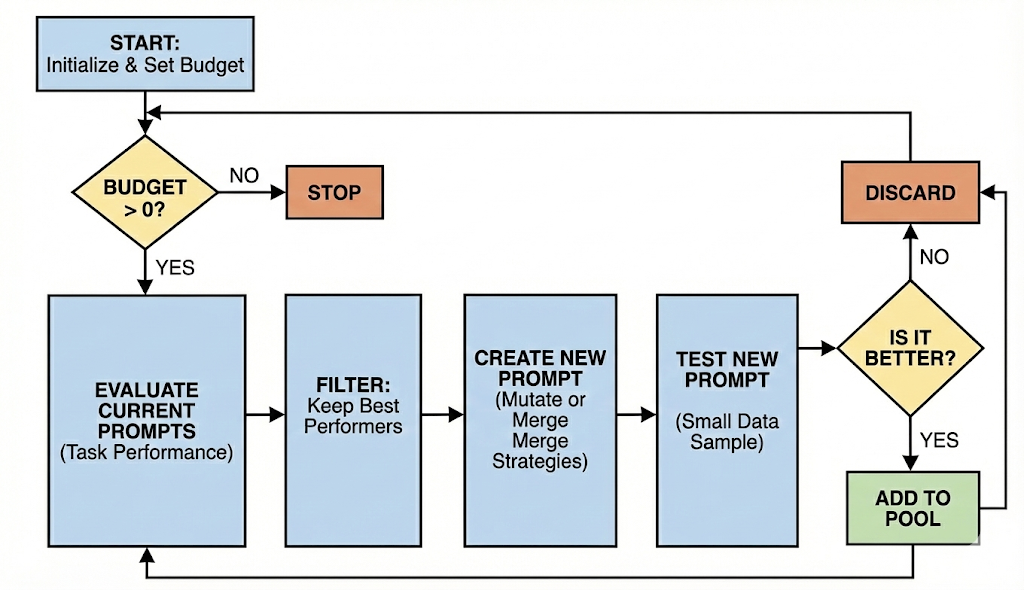

use this as example

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

```mm
flowchart TD
    A[START: Initialize & Set Budget] --> B{BUDGET > 0?}
    B -->|NO| C[STOP]
    B -->|YES| D[EVALUATE CURRENT PROMPTS<br/>Task Performance]
    D --> E[FILTER:<br/>Keep Best Performers]
    E --> F[CREATE NEW PROMPT<br/>Mutate or Merge Strategies]
    F --> G[TEST NEW PROMPT<br/>Small Data Sample]
    G --> H{IS IT BETTER?}
    H -->|YES| I[ADD TO POOL]
    H -->|NO| J[DISCARD]
    I --> B
    J --> B
```

You can paste this into any Mermaid-compatible renderer (like the solveit note with mermaid support, or mermaid.live). Want me to adjust the styling or add more detail?

In [ ]:
%%mm
flowchart LR
    A[🚀 START<br/>Initialize & Set Budget] --> B{BUDGET > 0?}
    B -->|NO| C[🛑 STOP]
    B -->|YES| D[📊 EVALUATE<br/>Current Prompts]
    D --> E[🔍 FILTER<br/>Keep Best]
    E --> F[✨ CREATE<br/>Mutate/Merge]
    F --> G[🧪 TEST<br/>Small Sample]
    G --> H{Better?}
    H -->|YES| I[✅ ADD<br/>to Pool]
    H -->|NO| J[❌ DISCARD]
    I --> B
    J --> B

chart be inside 3:2 ratio. boxes should have rounded corner. colour scheme should be as required for the loop

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

```mm
%%{init: {'theme': 'base', 'themeVariables': {'primaryColor': '#B8D4E8', 'primaryBorderColor': '#666', 'lineColor': '#333'}}}%%
flowchart LR
    A[🚀 START<br/>Initialize & Set Budget]:::blue --> B{BUDGET > 0?}:::orange
    B -->|NO| C[🛑 STOP]:::orange
    B -->|YES| D[📊 EVALUATE<br/>Current Prompts]:::blue
    D --> E[🔍 FILTER<br/>Keep Best]:::blue
    E --> F[✨ CREATE<br/>Mutate/Merge]:::blue
    F --> G[🧪 TEST<br/>Small Sample]:::blue
    G --> H{Better?}:::orange
    H -->|YES| I[✅ ADD to Pool]:::green
    H -->|NO| J[❌ DISCARD]:::red
    I --> B
    J --> B

    classDef blue fill:#B8D4E8,stroke:#555,rx:10,ry:10
    classDef orange fill:#F5D5A0,stroke:#555,rx:10,ry:10
    classDef green fill:#90EE90,stroke:#555,rx:10,ry:10
    classDef red fill:#F5A89A,stroke:#555,rx:10,ry:10
```

Note: Mermaid doesn't natively support fixed aspect ratios—you'd need to wrap it in a container div with CSS like `style="aspect-ratio: 3/2; max-width: 600px;"` to constrain it. Want me to show that wrapper approach?

In [ ]:
%%mm
%%{init: {'theme': 'base', 'themeVariables': {'primaryColor': '#B8D4E8', 'primaryBorderColor': '#666', 'lineColor': '#333'}}}%%
flowchart LR
    A[🚀 START<br/>Initialize & Set Budget]:::blue --> B{BUDGET > 0?}:::orange
    B -->|NO| C[🛑 STOP]:::orange
    B -->|YES| D[📊 EVALUATE<br/>Current Prompts]:::blue
    D --> E[🔍 FILTER<br/>Keep Best]:::blue
    E --> F[✨ CREATE<br/>Mutate/Merge]:::blue
    F --> G[🧪 TEST<br/>Small Sample]:::blue
    G --> H{Better?}:::orange
    H -->|YES| I[✅ ADD to Pool]:::green
    H -->|NO| J[❌ DISCARD]:::red
    I --> B
    J --> B

    classDef blue fill:#B8D4E8,stroke:#555,rx:10,ry:10
    classDef orange fill:#F5D5A0,stroke:#555,rx:10,ry:10
    classDef green fill:#90EE90,stroke:#555,rx:10,ry:10
    classDef red fill:#F5A89A,stroke:#555,rx:10,ry:10